A.S. Lundervold, 22.02.2024

# Introduction


Unlike humans, who can understand and process natural language directly, our computational models in NLP require text to be presented in a numerical, encoded format. Here's a high-level overview of the steps involved in a process of converting text into a format that can be used as input to a model:

**Tokenization**

First, we perform a process called tokenization, which breaks down text into smaller units called tokens. 

Tokenization is not a one-size-fits-all process, and there are multiple tokenization strategies, each with its strengths and weaknesses depending on the task. We'll look at some in this notebook. 

**Numericalization**

Once we have tokens, we convert them to numbers through numericalization. This is crucial because computers are designed to work with numbers, not words. 

**Batching**

Next, we group these numbers representing text into batches. Batching helps the computer handle lots of text simultaneously, making everything more efficient. The strategy for grouping text into batches can vary, affecting how the model learns and performs. We'll examine an effective batching approach for a language model.

**Embeddings**

Finally, we use embeddings to represent each token as a vector. Embeddings are used to capture more than just the identity of a token; they encode semantic relationships and meanings. This representation is critical for models to understand and predict based on the text. 


Taken together, these steps convert text data into batches of vectors that can be used as input to a model.

**The notebook is partly based on:**

* fastbook, Chapter 10: [NLP Deep Dive: RNNs](https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb), 2020
* fastai course, Lesson 4: [Natural Language (NLP)](https://course.fast.ai/Lessons/lesson4.html), 2023
* Sebastian Raschka, [Build a Large Language Model (From Skratch)](https://github.com/rasbt/LLMs-from-scratch), 2024

# Setup

In [1]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# or Kaggle, which makes some difference for the code below.
try:
    import google.colab
    colab=True
except:
    colab=False

import os
kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [2]:
if (colab or kaggle):
    %pip install -Uqq fastcore tiktoken

In [3]:
%matplotlib inline
from pathlib import Path
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastcore.all import *
import torch

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Load data

We use the works of William Shakespeare as our text data, as prepared by Andrej Karpathy here: https://cs.stanford.edu/people/karpathy/char-rnn/

In [4]:
text_shakespeare = 'https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt'

In [5]:
import textwrap
import urllib.request

def print_text(url, nb_lines=10, wrap_width=70):
    try:
        with urllib.request.urlopen(url) as f:
            for i in range(nb_lines):
                line = f.readline().decode('utf-8').strip()
                if line:
                    print('\n'.join(textwrap.wrap(line, wrap_width)))
    except urllib.error.URLError:
        print(f"Error opening URL {url}.")

In [6]:
print_text(text_shakespeare, nb_lines=20, wrap_width=70)

First Citizen:
Before we proceed any further, hear me speak.
All:
Speak, speak.
First Citizen:
You are all resolved rather to die than to famish?
All:
Resolved. resolved.
First Citizen:
First, you know Caius Marcius is chief enemy to the people.
All:
We know't, we know't.
First Citizen:
Let us kill him, and we'll have corn at our own price.


# Tokenization and numericalization

In [7]:
test_text = 'This is a test sentence. It includes -- some punctuation!? And some numbers 1, 2, 3.'

## Character tokenization

A simple strategy is to tokenize the text into characters:

In [8]:
tokens = list(test_text)
tokens[:10]

['T', 'h', 'i', 's', ' ', 'i', 's', ' ', 'a', ' ']

In [9]:
len(tokens)

84

To assign numbers to the tokens, i.e., **numericalization**, we can simply encode each character with a unique integer:

In [10]:
token2idx = {t: i for i, t in enumerate(sorted(set(tokens)))}

In [11]:
token2idx

{' ': 0,
 '!': 1,
 ',': 2,
 '-': 3,
 '.': 4,
 '1': 5,
 '2': 6,
 '3': 7,
 '?': 8,
 'A': 9,
 'I': 10,
 'T': 11,
 'a': 12,
 'b': 13,
 'c': 14,
 'd': 15,
 'e': 16,
 'h': 17,
 'i': 18,
 'l': 19,
 'm': 20,
 'n': 21,
 'o': 22,
 'p': 23,
 'r': 24,
 's': 25,
 't': 26,
 'u': 27}

To go back from numericalized tokens to text, we can use the following mapping:

In [12]:
idx2token = {i: t for t, i in token2idx.items()}

In [13]:
idx2token

{0: ' ',
 1: '!',
 2: ',',
 3: '-',
 4: '.',
 5: '1',
 6: '2',
 7: '3',
 8: '?',
 9: 'A',
 10: 'I',
 11: 'T',
 12: 'a',
 13: 'b',
 14: 'c',
 15: 'd',
 16: 'e',
 17: 'h',
 18: 'i',
 19: 'l',
 20: 'm',
 21: 'n',
 22: 'o',
 23: 'p',
 24: 'r',
 25: 's',
 26: 't',
 27: 'u'}

Now we can go back and forth between text and numericalized tokens:

In [14]:
test_text

'This is a test sentence. It includes -- some punctuation!? And some numbers 1, 2, 3.'

In [15]:
tokens = list(test_text)

In [16]:
tokens2idxs = np.array([token2idx[t] for t in tokens])

In [17]:
tokens2idxs

array([11, 17, 18, 25,  0, 18, 25,  0, 12,  0, 26, 16, 25, 26,  0, 25, 16,
       21, 26, 16, 21, 14, 16,  4,  0, 10, 26,  0, 18, 21, 14, 19, 27, 15,
       16, 25,  0,  3,  3,  0, 25, 22, 20, 16,  0, 23, 27, 21, 14, 26, 27,
       12, 26, 18, 22, 21,  1,  8,  0,  9, 21, 15,  0, 25, 22, 20, 16,  0,
       21, 27, 20, 13, 16, 24, 25,  0,  5,  2,  0,  6,  2,  0,  7,  4])

In [18]:
print(''.join([idx2token[i] for i in tokens2idxs]))

This is a test sentence. It includes -- some punctuation!? And some numbers 1, 2, 3.


This tokenization strategy ignores the structure in the text and is not very useful for most language tasks. Rather, we want to preserve some of the structure in the text when tokenizing it. Let's look at some other strategies.

## Tokenize by matching string patterns

In [19]:
import re

In [20]:
def basic_tokenization(text, pattern, include_whitespace=False, verbose=False):
    """
    Tokenizes the input text based on the provided pattern.

    Parameters:
    text (str): The text to tokenize.
    pattern (str): The pattern to use for tokenization.
    include_whitespace (bool): If True, includes whitespace as a tokens.

    Returns:
    list: The list of tokens.
    """
    result = re.split(pattern, text)
    if not include_whitespace:
        result = [item.strip() for item in result if item.strip()]
    if verbose:
        print("Whitespace included:", include_whitespace)
        print("Input:", text)
        print("Length of input:", len(text))
        print("Result:", result)
        print("Number of tokens:", len(result))
    return result

### Word tokenization by splitting on whitespace

In [21]:
_ = basic_tokenization(test_text, r'(\s)', include_whitespace=False, verbose=True)

Whitespace included: False
Input: This is a test sentence. It includes -- some punctuation!? And some numbers 1, 2, 3.
Length of input: 84
Result: ['This', 'is', 'a', 'test', 'sentence.', 'It', 'includes', '--', 'some', 'punctuation!?', 'And', 'some', 'numbers', '1,', '2,', '3.']
Number of tokens: 16


In [22]:
_ = basic_tokenization(test_text, r'(\s)', include_whitespace=True, verbose=True)

Whitespace included: True
Input: This is a test sentence. It includes -- some punctuation!? And some numbers 1, 2, 3.
Length of input: 84
Result: ['This', ' ', 'is', ' ', 'a', ' ', 'test', ' ', 'sentence.', ' ', 'It', ' ', 'includes', ' ', '--', ' ', 'some', ' ', 'punctuation!?', ' ', 'And', ' ', 'some', ' ', 'numbers', ' ', '1,', ' ', '2,', ' ', '3.']
Number of tokens: 31


One would never use this in practice, as it's very inefficient and uses no features of language except that words tend to, in many languages, be separated by spaces. Among other things, we lose punctuation and the fact that some words are contractions of multiple words (for example "here's", "isn't", and "don't"). By specifying a set of rules, we can do better.

<img src="https://spacy.io/images/tokenization.svg"> <br> <small>Illustration from spaCy's documentation: https://spacy.io/usage/linguistic-features#tokenization</small>

### Split on whitespace and punctuation

Split on commas and periods:

In [23]:
_ = basic_tokenization(test_text, r'([,.]|\s)', include_whitespace=False, verbose=True)

Whitespace included: False
Input: This is a test sentence. It includes -- some punctuation!? And some numbers 1, 2, 3.
Length of input: 84
Result: ['This', 'is', 'a', 'test', 'sentence', '.', 'It', 'includes', '--', 'some', 'punctuation!?', 'And', 'some', 'numbers', '1', ',', '2', ',', '3', '.']
Number of tokens: 20


Add additional punctuation:

In [24]:
_ = basic_tokenization(test_text, r'([,.?_!"()\']|--|\s)', include_whitespace=False, verbose=True)

Whitespace included: False
Input: This is a test sentence. It includes -- some punctuation!? And some numbers 1, 2, 3.
Length of input: 84
Result: ['This', 'is', 'a', 'test', 'sentence', '.', 'It', 'includes', '--', 'some', 'punctuation', '!', '?', 'And', 'some', 'numbers', '1', ',', '2', ',', '3', '.']
Number of tokens: 22


> **Your turn!** Experiment with different pattern values in the `basic_tokenizer` function. Note the effect on the number of tokens and the tokens themselves.

## Apply tokenization to the entire text corpus

In [25]:
pattern = r'([,.?_!"():&\']|--|\s)'

In [26]:
try:
    with urllib.request.urlopen(text_shakespeare) as response:
        data = response.read().decode('utf-8')

    preprocessed = basic_tokenization(data, pattern, include_whitespace=False)
    preprocessed = [item.lower() for item in preprocessed]
    # Get the frequency of each token
    token_counts = pd.Series(preprocessed).value_counts()
    # Get the number of unique tokens
    nb_tokens = len(token_counts)

except urllib.error.URLError:
        print(f"Error opening URL {text_shakespeare}.")

In [27]:
len(preprocessed), preprocessed[:20]

(1054375,
 ['first',
  'citizen',
  ':',
  'before',
  'we',
  'proceed',
  'any',
  'further',
  ',',
  'hear',
  'me',
  'speak',
  '.',
  'all',
  ':',
  'speak',
  ',',
  'speak',
  '.',
  'first'])

Here are the most common tokens in the dataset:

In [28]:
token_counts.head(10)

,      79977
:      44576
.      33850
the    26221
'      24028
and    23528
i      21808
to     18163
of     16341
you    13551
Name: count, dtype: int64

In [29]:
# Total number of tokens
nb_tokens

29021

## Building a vocabulary

If we want to map a string to a set of tokens, we need to have a fixed set of tokens to map to. Moreover, if we want to decode a set of tokens to a string, we need to have a fixed set of tokens to map from. This is the motivation for building a **vocabulary**.

As an example, consider our test text

In [30]:
test_text

'This is a test sentence. It includes -- some punctuation!? And some numbers 1, 2, 3.'

As we recall, this can be tokenized by splitting on whitespace and punctuation:

In [31]:
pattern = r'([,.?_!"():&\']|--|\s)'

In [32]:
tokens = basic_tokenization(test_text, pattern, include_whitespace=False, verbose=False)
tokens

['This',
 'is',
 'a',
 'test',
 'sentence',
 '.',
 'It',
 'includes',
 '--',
 'some',
 'punctuation',
 '!',
 '?',
 'And',
 'some',
 'numbers',
 '1',
 ',',
 '2',
 ',',
 '3',
 '.']

From this, we can construct a vocabulary. Here's a first, simple approach: sort the tokens alphabetically and assign an index to each token:

In [33]:
all_words = sorted(list(set(tokens)))
vocab_size = len(all_words)

In [34]:
all_words

['!',
 ',',
 '--',
 '.',
 '1',
 '2',
 '3',
 '?',
 'And',
 'It',
 'This',
 'a',
 'includes',
 'is',
 'numbers',
 'punctuation',
 'sentence',
 'some',
 'test']

In [35]:
vocab_size

19

Then we can map the unique tokens to unique token indices:

In [36]:
vocab = {token:integer for integer, token in enumerate(all_words)}

In [37]:
vocab

{'!': 0,
 ',': 1,
 '--': 2,
 '.': 3,
 '1': 4,
 '2': 5,
 '3': 6,
 '?': 7,
 'And': 8,
 'It': 9,
 'This': 10,
 'a': 11,
 'includes': 12,
 'is': 13,
 'numbers': 14,
 'punctuation': 15,
 'sentence': 16,
 'some': 17,
 'test': 18}

<img src="https://github.com/HVL-ML/DAT255/blob/main/nbs/assets/building_a_vocabulary_from_corpus.png?raw=true" width=80%>

### Building a vocabulary from the entire text corpus

Let's apply this to the entire text corpus:

In [38]:
all_words = sorted(list(set(preprocessed)))
vocab_size = len(all_words)

In [39]:
vocab_size

29021

> Note that having a large vocab size means that we will end up with a large number of parameters in our model. For example, if you have a vocab size of 100,000, and your first layer in the network compresses this to 1024 dimensional word embeddings, then the first layer will have 100.000 x 1000 = 100 million parameters. Just for the first layer! This is why we often use subword tokenization, which we'll look at later.

In [40]:
vocab = {token:integer for integer, token in enumerate(all_words)}

In [41]:
import itertools

for item in itertools.islice(vocab.items(), 31):
    print(item)

('!', 0)
('&', 1)
("'", 2)
(',', 3)
('-', 4)
('--', 5)
('-but', 6)
('-groves', 7)
('-guts', 8)
('.', 9)
('3', 10)
(':', 11)
(';', 12)
('?', 13)
('[and', 14)
('[gower]', 15)
('[prospero]', 16)
(']', 17)
('a', 18)
('a-bed', 19)
('a-bed;', 20)
('a-birding', 21)
('a-birding;', 22)
('a-bleeding', 23)
('a-bleeding;', 24)
('a-breeding', 25)
('a-brewing', 26)
('a-cold', 27)
('a-cursing', 28)
('a-day', 29)
('a-doing', 30)


## A tokenizer class

We can create a class to wrap our encoding and decoding functions. It needs to store the vocab and provide a method to encode a string and decode a list of tokens.

In [42]:
class OurTokenizerV1:
    def __init__(self, vocab, pattern):
        """
        Initialize the tokenizer with a vocabulary.
        
        Parameters:
        vocab (dict): A dictionary mapping strings to integers.
        pattern (str): The pattern to use for tokenization.
        """
        self.pattern = pattern
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        """
        Encode a text string into a list of integers.
        
        Parameters:
        text (str): The text to encode.
        
        Returns:
        list: The encoded text.
        """
        preprocessed = basic_tokenization(text, self.pattern, include_whitespace=False)
        preprocessed = [item.lower() for item in preprocessed]
        return [self.str_to_int[s] for s in preprocessed]  
    
    def decode(self, ids):
        """
        Decode a list of integers into a text string.
        
        Parameters:
        ids (list): The list of integers to decode.
        
        Returns:
        str: The decoded text.
        """
        text = " ".join([self.int_to_str[i] for i in ids]) 

        text = re.sub(self.pattern, r'\1', text)

        return text

Let's test it using the pattern and vocab from earlier:

In [43]:
pattern

'([,.?_!"():&\\\']|--|\\s)'

In [44]:
tokenizer = OurTokenizerV1(vocab, pattern)

In [45]:
ids = tokenizer.encode("First, you know Caius Marcius is chief enemy to the people.")
ids

[9703, 3, 28983, 14013, 3553, 15403, 13517, 4288, 8308, 25668, 25232, 18374, 9]

In [46]:
tokenizer.decode(ids)

'first , you know caius marcius is chief enemy to the people .'

What happens if we use a token that is not in the vocabulary?

In [47]:
tokenizer.encode("This sentence contains words that are not in the vocabulary. For example, antidisestablishmentarianism")

KeyError: 'vocabulary'

We have to deal with this somehow, as we can't guarantee that the tokenized text will only contain tokens from the vocabulary.

## Adding special tokens

To deal with unknown tokens, we can add a special token to the vocabulary: the `<|unk|>` token. 

In [48]:
all_words.extend(["<|unk|>"])

In [49]:
vocab = {token:integer for integer, token in enumerate(all_words)}

In [50]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('zodiacs', 29017)
('zone', 29018)
('zounds', 29019)
('zwaggered', 29020)
('<|unk|>', 29021)


Our new token is added and has the token ID of 29021.

A small update to our tokenizer class can handle unknown tokens:

In [51]:
class OurTokenizerV2:
    def __init__(self, vocab, pattern):
        """
        Initialize the tokenizer with a vocabulary.
        
        Parameters:
        vocab (dict): A dictionary mapping strings to integers.
        pattern (str): The pattern to use for tokenization.
        """
        self.pattern = pattern
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        """
        Encode a text string into a list of integers.
        
        Parameters:
        text (str): The text to encode.
        
        Returns:
        list: The encoded text.
        """
        preprocessed = basic_tokenization(text, self.pattern, include_whitespace=False)
        preprocessed = [item.lower() for item in preprocessed]
        preprocessed = [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]
        return [self.str_to_int[s] for s in preprocessed]  
    
    def decode(self, ids):
        """
        Decode a list of integers into a text string.
        
        Parameters:
        ids (list): The list of integers to decode.
        
        Returns:
        str: The decoded text.
        """
        text = " ".join([self.int_to_str[i] for i in ids]) 

        text = re.sub(self.pattern, r'\1', text)

        return text

In [52]:
tokenizer2 = OurTokenizerV2(vocab, pattern)

In [53]:
idxs = tokenizer2.encode("This sentence contains words that are not in the vocabulary. For example, antidisestablishmentarianism")
idxs

[25342,
 22245,
 5330,
 28728,
 25224,
 1209,
 17079,
 12950,
 25232,
 29021,
 9,
 10044,
 8859,
 3,
 29021]

In [54]:
tokenizer2.decode(idxs)

'this sentence contains words that are not in the <|unk|> . for example , <|unk|>'

## Subword tokenization and byte-pair encoding (BPE)

### Subword tokenization

Subword tokenization is a method that finds a middle ground between breaking down text into single characters and keeping them as whole words. It works by splitting words into smaller pieces. This way, common words stay as they are, but rare words get broken down into parts that we see more often.

Modern subword tokenizers tend to be _trained_ on the text corpus you're interested in (or pre-trained on a large corpus that you want to train a model that you can use for fine-tuning). 

### Byte-Pair encoding: an example of training an encoder

When faced with a particular text corpus the above rules-based tokenizers can often be both wasteful (with superfluous tokens for words that doen't appear in your corpus) and inefficient (for example, lacking tokens that can represent important and often-used words in your particular corpus). 

Tokenizers based on _training_, i.e. identification of important words or word pieces, can therefore be useful, and this is thus part of most modern tokenizers. An example is the **byte pair encoding** used by, among others, GPT models. 

The Byte Pair Encoding (BPE) was first introduced for data compression by finding and combining common pairs of letters or bytes. 

> It was introduced by Philip Gage in 1994 for data compression (_"a simple general-purpose data compression algorithm"_), based on identifying common byte pairs. Here's a copy of the original article http://www.pennelynn.com/Documents/CUJ/HTML/94HTML/19940045.HTM. See also Wikipedia for a simple example of BPE used for data compression: https://en.wikipedia.org/wiki/Byte_pair_encoding

Currently, it's commonly used in language processing to figure out which pieces of words to combine to make our vocabulary better suited to the text we're working with. 

The procedure is roughly the following: 

```
1. Add identifiers marking the end of each word
2. Calculate the word frequencies in the text corpus
3. Split the words into characters and calculate the character frequencies
4. From character tokens, count the frequency of consecutive byte pairs and merge the most frequent byte pair
5. Continue until a manually defined iteration limit is reached, or the token limit is reached. 
```

This method is straightforward and focuses on what's seen most often. It makes our vocabulary more relevant to the text, especially when dealing with unusual words.

> This is a greedy algorithm. Non-greedy variants exist and other tweaks to BPE are in use.

> Pros and cons: Using BPE makes our vocabulary more flexible and efficient. It's especially good at handling rare words without needing a huge list of every possible word. However, because it always looks for the most common pairs, it might not always create the best possible combination for every situation. Plus, figuring out when to stop combining letters can be tricky.

Rather than implementing BPE from scratch, we can use `tiktoken` to grab a trained BPE tokenizer.

In [57]:
%pip install -Uqq tiktoken

Note: you may need to restart the kernel to use updated packages.


In [58]:
import tiktoken

In [59]:
tokenizer = tiktoken.get_encoding("gpt2")

In [60]:
test_text = "This sentence contains words that are not in the vocabulary. For example, antidisestablishmentarianism"

In [61]:
idxs = tokenizer.encode(test_text)
idxs

[1212,
 6827,
 4909,
 2456,
 326,
 389,
 407,
 287,
 262,
 25818,
 13,
 1114,
 1672,
 11,
 1885,
 29207,
 44390,
 3699,
 1042]

In [62]:
len(test_text.split()), len(idxs)

(13, 19)

In [63]:
tokenizer.decode(idxs)

'This sentence contains words that are not in the vocabulary. For example, antidisestablishmentarianism'

In [64]:
tokenizer.encode("antidisestablishmentarianism")

[415, 29207, 44390, 3699, 1042]

In [65]:
for i in tokenizer.encode("antidisestablishmentarianism"):
    print(tokenizer.decode([i]))

ant
idis
establishment
arian
ism


# Batching and dataloaders

_TBA_

# Embeddings

So far, we've learned how to break down text into tokens (words, subwords, etc.) and represent them as simple numerical indices. While that's a necessary first step, there are two problems: 

(i) These numerical representations don't capture the meaning or relationships between words;<br>
(ii) our deep neural network models require continuous vector representations as inputs, as they are trained using backpropagation and gradient descent.

This is where embeddings come into play.

## Key concepts



**Vector representations:** Embeddings represent words (or tokens) as dense vectors of numbers, aiming to place words with similar contexts closer together.

**Semantic similarity:** Instead of just an arbitrary number, an embedding vector tries to capture a word's meaning and its relationships with other words. Semantically similar words (e.g., 'cat' and 'dog') would ideally have embeddings closer together in the vector space.

> Note that embeddings aren't restricted to words or word-based tokens. They can also represent entire sentences, paragraphs, or even code.

## Types of embeddings

### Pre-trained embeddings


Pre-trained embeddings are embeddings trained on a large corpus of text. They are often trained using unsupervised learning methods like word2vec, GloVe, or fastText. These embeddings are then used as a starting point for training a model on a specific task, such as sentiment analysis or named entity recognition. As the embeddings are trained on massive text datasets, they can contain rich semantic information.

#### Example

In [66]:
%pip install -Uqq torchtext

Note: you may need to restart the kernel to use updated packages.


In [67]:
import torch
import torchtext.vocab as vocab

In [68]:
glove = vocab.GloVe(name='6B', dim=100) # Example: Load 100-dimensional GloVe embeddings

In [69]:
# Getting the embedding for a word
word_embedding = glove.get_vecs_by_tokens('hello') 

In [70]:
word_embedding

tensor([ 0.2669,  0.3963,  0.6169, -0.7745, -0.1039,  0.2670,  0.2788,  0.3099,
         0.0055, -0.0853,  0.7360, -0.0984,  0.5479, -0.0303,  0.3348,  0.1409,
        -0.0070,  0.3257,  0.2290,  0.4656, -0.1953,  0.3749, -0.7139, -0.5178,
         0.7704,  1.0881, -0.6601, -0.1623,  0.9119,  0.2105,  0.0475,  1.0019,
         1.1133,  0.7009, -0.0870,  0.4757,  0.1636, -0.4447,  0.4469, -0.9382,
         0.0131,  0.0860, -0.6746,  0.4966, -0.0378, -0.1104, -0.2861,  0.0746,
        -0.3153, -0.0938, -0.5707,  0.6686,  0.4531, -0.3415, -0.7166, -0.7527,
         0.0752,  0.5790, -0.1191, -0.1138, -0.1003,  0.7134, -1.1574, -0.7403,
         0.4045,  0.1802,  0.2145,  0.3764,  0.1124, -0.5364, -0.0251,  0.3189,
        -0.2501, -0.6328, -0.0118,  1.3770,  0.8601,  0.2048, -0.3681, -0.6887,
         0.5351, -0.4656,  0.2739,  0.4118, -0.8540, -0.0463,  0.1130, -0.2733,
         0.1564, -0.2033,  0.5359,  0.5978,  0.6047,  0.1373,  0.4223, -0.6128,
        -0.3849,  0.3584, -0.4846,  0.30

### Measuring distance and similarity

In [71]:
# Euclidean distance

x = glove['cat']
y = glove['dog']

print("Euclidean distance between 'cat' and 'dog':")
print(torch.norm(y - x))

Euclidean distance between 'cat' and 'dog':
tensor(2.6811)


In [72]:
# Euclidean distance

x = glove['cat']
y = glove['continent']

print("Euclidean distance between 'cat' and 'continent':")
print(torch.norm(y - x))

Euclidean distance between 'cat' and 'continent':
tensor(6.5621)


In [73]:
# Cosine similarity

x = glove['cat']
y = glove['dog']

print("Cosine similarity between 'cat' and 'dog':")

print(torch.cosine_similarity(x.unsqueeze(0), y.unsqueeze(0)))

Cosine similarity between 'cat' and 'dog':
tensor([0.8798])


Because 'cat' and 'dog' are semantically similar, their embeddings being close in the vector space helps our models generalize better, even if the word 'dog' didn't appear frequently in training data.

In [74]:
# What is the cosine similarity? 

def cosine_similarity(u, v):
    """
    Returns the cosine of the angle between vectors `u` and `v`.
    """

    return torch.dot(u, v) / (torch.norm(u) * torch.norm(v))



When calculating cosine similarity between word embeddings, we measure the angle between their corresponding vectors.

**Vectors and angles**:  Imagine each word's embedding as a vector in a high-dimensional space.  The cosine similarity tells us how much these vectors point in the same direction.

Similarity:

* Cosine similarity ranges from -1 to 1.
* A value of 1 means the vectors are perfectly aligned (angle = 0 degrees), indicating very similar words.
* A value of 0 means the vectors are orthogonal (angle = 90 degrees), suggesting no relationship.
* A value of -1 means the vectors point in opposite directions (angle = 180 degrees), implying antonyms or highly dissimilar words.

> **Key takeaway**:  Cosine similarity provides a way to quantify semantic relationships between words based on the geometry of their embeddings.

In [75]:
# Measuring distance from a given word to a list of other words
word = 'cat'
other = ['dog', 'bike', 'kitten', 'puppy', 'kite', 'computer', 'neuron']

for w in other:
    dist = torch.norm(glove[word] - glove[w]) # euclidean distance
    print(w, float(dist))

dog 2.681130886077881
bike 6.0225629806518555
kitten 4.454165935516357
puppy 3.9275598526000977
kite 5.85930061340332
computer 6.960630893707275
neuron 7.568032264709473


In [76]:
def find_similar_words(word, glove, top_n=10):
    """Finds the top_n most similar words to the given word using GloVe embeddings.

    Args:
        word (str): The input word.
        glove: A GloVe object containing word embeddings.
        top_n (int, optional): The number of similar words to return. Defaults to 10.

    Returns:
        list: A list of strings representing the most similar words.
    """

    try:
        word_embedding = glove.get_vecs_by_tokens(word)
        similarities = torch.cosine_similarity(glove.vectors, word_embedding)
        top_n_similar = torch.topk(similarities, k=top_n)
        top_n_words = [glove.itos[i] for i in top_n_similar.indices]
        return top_n_words

    except KeyError:
        print(f"Word '{word}' not found in the GloVe vocabulary.")
        return []

In [77]:
find_similar_words("dog", glove)

['dog', 'cat', 'dogs', 'pet', 'puppy', 'horse', 'animal', 'pig', 'boy', 'cats']

In [78]:
find_similar_words("computer", glove)

['computer',
 'computers',
 'software',
 'technology',
 'pc',
 'hardware',
 'internet',
 'desktop',
 'electronic',
 'systems']

In [79]:
find_similar_words("norway", glove)

['norway',
 'denmark',
 'sweden',
 'finland',
 'iceland',
 'norwegian',
 'austria',
 'switzerland',
 'greece',
 'germany']

#### Visualizing embeddings

/opt/anaconda3/envs/dat255/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


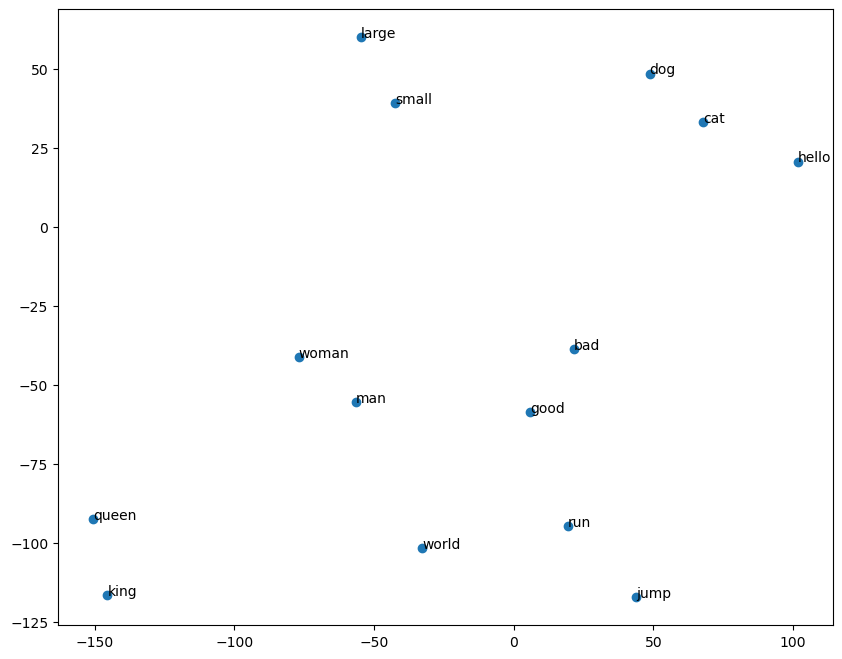

In [80]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Sample words for visualization
sample_words = ['hello', 'world', 'cat', 'dog', 'king', 'queen', 'man', 'woman', 
                'good', 'bad', 'run', 'jump', 'large', 'small'] 

sample_embeddings = glove.get_vecs_by_tokens(sample_words)

# Convert the embeddings to a NumPy array 
sample_embeddings_np = sample_embeddings.numpy()

# Reduce dimensionality with t-SNE
X_embedded = TSNE(n_components=2, perplexity=4).fit_transform(sample_embeddings_np)

# Plot the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])

# Add labels for individual words 
for i, word in enumerate(sample_words):
    plt.annotate(word, xy=(X_embedded[i, 0], X_embedded[i, 1]))

plt.show()

In the visualization, notice how semantically related words tend to cluster together while unrelated words are farther apart.

See also the interactive demonstrations we used in class based on http://projector.tensorflow.org/.

### Learned embeddings

Learned embeddings are embeddings that are trained from scratch on a specific task. For example, when training a language model, the model learns to predict the next word in a sentence, and in the process, it learns to represent words as dense vectors. This allows embeddings to be fine-tuned specifically for our task.

## Creating embedding vectors from skratch using PyTorch

# _MORE TBA_